In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from matplotlib.ticker import PercentFormatter
import matplotlib.gridspec as gridspec
import itertools
import string
import numpy as np
import warnings
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings("ignore")

# OR por agravo e população

In [6]:
# Função para verificar o p-valor
def check_p_value(p_val):
    if 'p<' in p_val:
        return float(p_val.split('<')[1]) == 0.001 or float(p_val.split('<')[1]) == 0.05
    elif 'p=' in p_val:
        return float(p_val.split('=')[1]) == 0.001 or float(p_val.split('=')[1]) == 0.05
    return False

def label_f(df_or, df_p):
    # Create labels with OR and p-values, adding '*' to significant p-values
    label1 = round(df_or.iloc[:,0], 2).astype('str') + '\n' + df_p.iloc[:,0]
    label2 = round(df_or.iloc[:,1], 2).astype('str') + '\n' + df_p.iloc[:,1]
    label3 = round(df_or.iloc[:,2], 2).astype('str') + '\n' + df_p.iloc[:,2]
    label4 = round(df_or.iloc[:,3], 2).astype('str') + '\n' + df_p.iloc[:,3]

    labels = pd.DataFrame(dict(label1=label1, label2=label2, label3=label3, label4=label4))
    return labels


def heatmap(df, name, rotulo, metric):
    global df_or, df_data, df_data_or, labels
    
    df_data = df.copy()

    # Aplicar a substituição para cada coluna
    for column in ['PPL_or', 'PSR_or', 'ProfSau_or', 'Imi_or']:
        p_column = column.replace('_or', '_p')
        df_data[column] = df_data.apply(lambda row: 0 if not check_p_value(row[p_column]) else row[column], axis=1)

    df.rename(columns={'PPL_or':'PPL', 'PSR_or':'PSR', 
                        'ProfSau_or':'ProfSau', 'Imi_or':'Imi'},
                        inplace=True)

    df.rename(columns={'PPL_p':'PPL', 'PSR_p':'PSR', 
                        'ProfSau_p':'ProfSau', 'Imi_p':'Imi'},
                        inplace=True)

    df_data.rename(columns={'PPL_or':'PPL', 'PSR_or':'PSR', 
                        'ProfSau_or':'ProfSau', 'Imi_or':'Imi'},
                        inplace=True)

    df_data.rename(columns={'PPL_p':'PPL', 'PSR_p':'PSR', 
                        'ProfSau_p':'ProfSau', 'Imi_p':'Imi'},
                        inplace=True)

    posicao = 0
    posicoes = [*itertools.product(range(0, LINHAS), range(0, COLUNAS))]

    fig, axs = plt.subplots(LINHAS, COLUNAS, figsize=FIGSIZE)

    # Custom color map: blue (0 to <1), white (1), red (>1)
    # colors = [(0, "white"), (0.01, "#4169E1"), (1/10, "white"), (1, "#a52a2a")]  # OR=1 is white
    colors = [(0, "white"), (0.01, "#4169E1"), (1/15, "white"), (2/10, "#f35f58"), (1, "#a52a2a")]  # OR=1 is white
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

    for evolucao in df['Evolucao'].unique():
            
        df_evolucao = df.loc[df['Evolucao'] == evolucao, :]
        df_data_evolucao = df_data.loc[df_data['Evolucao'] == evolucao, :]

        df_or = df_evolucao.iloc[:, 0:4]
        df_data_or = df_data_evolucao.iloc[:, 0:4]
        df_p = df_evolucao.iloc[:, 4:8]

        if metric == 'or':
            # labels = 'OR=' + (round(df_or, 2).astype('str') + '\n' + df_p).reset_index(drop=True)
            labels = label_f(df_or, df_p)
        elif metric == 'rr':
            labels = label_f(df_or, df_p)
    
        posicao_grafico = posicoes[posicao]
        ax = sns.heatmap(data=df_data_or, cmap=cmap, vmin=VMIN, vmax=VMAX,
                        robust=True, annot=labels, fmt='', annot_kws={'size':8, 'color':'black'},
                        ax=axs[posicao_grafico], linecolor ='black', linewidths = 0.5, cbar=False, 
                        square=False)
        # cbar = ax.collections[0].colorbar
        # cbar.ax.tick_params(axis='y', which='major', length=0, labelsize=10)
        
        ax.set_xlabel(f"{evolucao} - {rotulo}", fontsize=10)
        ax.set_ylabel(None)
        # ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.tick_params(axis='both', which='major', labelsize=10)

        ax.text(-0.1, 1.05, string.ascii_uppercase[posicao], transform=ax.transAxes, 
            size=11, weight='bold')
        
        posicao += 1

    for delete in range(posicao, LINHAS * COLUNAS):
        fig.delaxes(ax=axs[posicoes[delete]])

    plt.subplots_adjust(left=0.1,
                        # bottom=0.5, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.25, 
                        hspace=0.35)

    # Adicionar uma única barra de cores ao lado da figura
    if VMAX >= 12:
        cbar_ax = fig.add_axes([0.91, 0.3, 0.02, 0.4])  # [esquerda, inferior, largura, altura]
    else:
        cbar_ax = fig.add_axes([0.91, 0.55, 0.02, 0.3])  
        
    norm = plt.Normalize(vmin=VMIN, vmax=VMAX)
    # RdBu_r
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=cbar_ax)
    if VMAX >= 12:
        cbar.set_ticks([0, 1, 3, 6, 9, 12, 15])
        ax.text(2.272, 4.82, 'OR', transform=ax.transAxes, 
            size=10, weight='bold')
    else:
        cbar.set_ticks([0, 1, 2, 4, 6, 8, 10])
        ax.text(2.272, 6.05, 'OR', transform=ax.transAxes, 
                size=10, weight='bold')
    
    plt.savefig(f"{name}.jpg", dpi=400, bbox_inches = "tight")
        

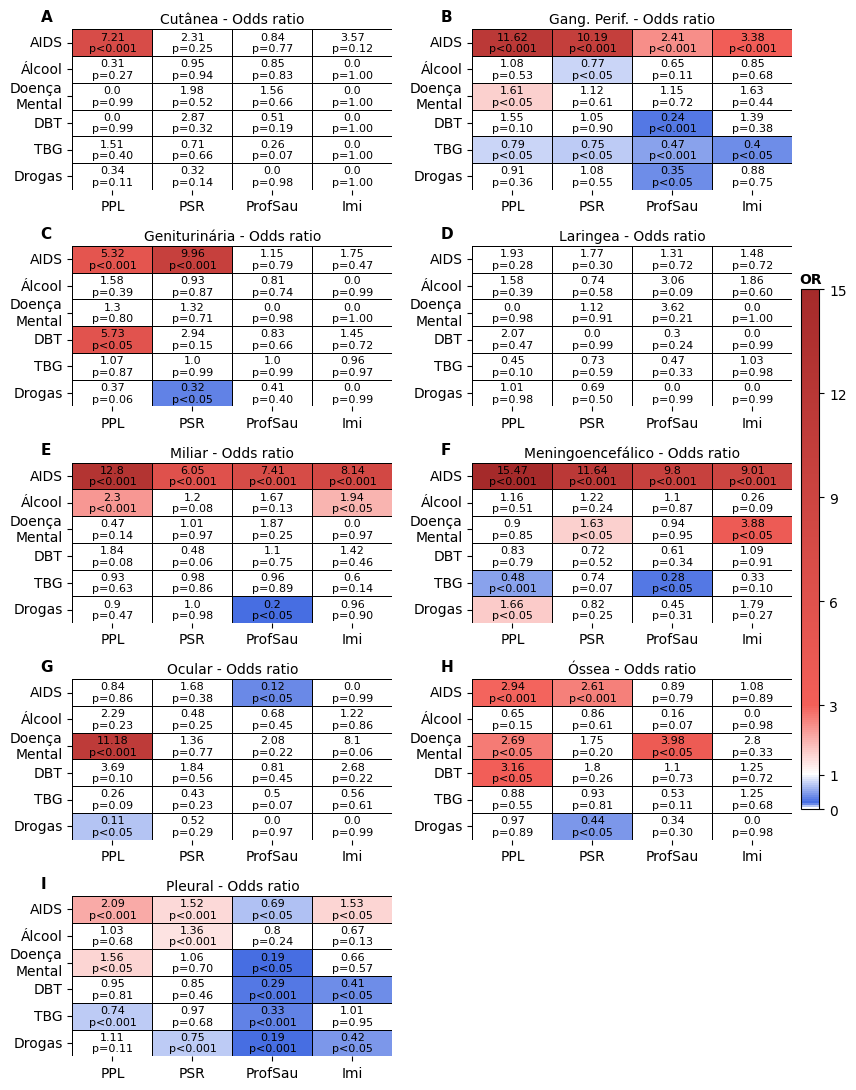

In [7]:
df = pd.read_csv('am_combined_orig (1º).csv')
df['agravos'] = df['agravos'].str.replace('\r','')
df.set_index('agravos', inplace=True)

LINHAS = 5
COLUNAS = 2
VMIN = 0
VMAX = 15
FIGSIZE = (9, 13)

heatmap(df, 'figura 1 - formas_clinicas', 'Odds ratio', 'or')

# Mortalidade

In [8]:
df = pd.read_csv('ab_rr_obito_desf.csv')
df['agravos'] = df['agravos'].str.replace('\r','')

column_names = ['PPL_rr', 'PSR_rr', 'ProfSau_rr', 'Imi_rr', 'PPL',  'PSR', 'ProfSau','Imi', 'Evolucao']

# df = df.iloc[:, [0,2,4,6,1,3,5,7,8]].copy()

LINHAS = 5
COLUNAS = 2
VMIN = 0
VMAX = 15
FIGSIZE = (9, 13)

# heatmap(df, 'figura 3 - rr - obitos', 'Relative Risk')
df.head()

,agravos,PPL_rr,PPL_lower,PPL_upper,PPL_p,PSR_rr,PSR_lower,PSR_upper,PSR_p,ProfSau_rr,ProfSau_lower,ProfSau_upper,ProfSau_p,Imi_rr,Imi_lower,Imi_upper,Imi_p,Evolucao
0,AIDS,2.190799,0.975318,4.921064,p=0.08,0.314286,0.103070,0.958336,p<0.05,0.000000,0.000000,NaN,p=1.00,1.649123,0.433959,6.266969,p=0.37,Pleural
1,Alcool,1.201672,0.490064,2.946587,p=0.76,1.187415,0.928279,1.518889,p=0.25,11.051429,3.218817,37.943779,p<0.05,1.768519,0.243707,12.833693,p=0.46,Pleural
2,Doença\nMental,0.000000,0.000000,NaN,p=1.00,0.683333,0.164818,2.833098,p=1.00,0.000000,0.000000,NaN,p=1.00,0.000000,0.000000,NaN,p=1.00,Pleural
3,DBT,5.918159,1.450917,24.139636,p=0.05,2.050000,0.579636,7.250245,p=0.23,3.659091,0.567466,23.594255,p=0.25,0.000000,0.000000,NaN,p=1.00,Pleural
4,TBG,0.671991,0.276908,1.630763,p=0.47,1.220230,0.874366,1.702902,p=0.31,7.539062,2.165076,26.251952,p<0.05,0.000000,0.000000,NaN,p=0.60,Pleural


In [9]:
def plot_rr_with_ci(ax, data, population, forma, posicao, h=-0.1):
    # Filtrar as colunas de interesse para a população específica
    rr_col = f'{population}_rr'
    lower_col = f'{population}_lower'
    upper_col = f'{population}_upper'
    p_col = f'{population}_p'
    
    plot_data = data.loc[data['Evolucao'] == forma]

    plot_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    plot_data = plot_data.loc[plot_data[f'{population}_rr'].notna() & plot_data[f'{population}_rr']]

    plot_data['agravos'] = plot_data['agravos'].map(
        {'AIDS': 'AIDS', 'Alcool':'Alc', 'Doença\nMental':'Ment', 'DBT':'DBT', 'TBG':'TBG', 'Drogas':'Drog'})

    # Selecionar as colunas necessárias
    # plot_data = data[['agravos', rr_col, lower_col, upper_col]]
    
    colors = ['yellow' if p_value in ['p<0.05', 'p<0.01', 'p<0.001'] else 'skyblue' for p_value in plot_data[p_col]]
    
    bars = ax.bar(plot_data['agravos'], plot_data[rr_col], linewidth=1, color=colors, edgecolor='black')
    
    # bars = ax.bar(plot_data['agravos'], plot_data[rr_col], linewidth=1, color='skyblue', edgecolor='black')
    ax.errorbar(plot_data['agravos'], plot_data[rr_col], yerr=[plot_data[rr_col] - plot_data[lower_col],
           plot_data[upper_col] - plot_data[rr_col]], capsize=3, elinewidth=1, fmt='none')

        # Adicionar anotações das colunas p_col
    for bar, rr, p_value in zip(bars, plot_data[rr_col], plot_data[p_col]):
        height = bar.get_height()
        ax.annotate(f"rr={round(rr,2)}\n{p_value}",  # Formato do valor p
                    xy=(bar.get_x() + bar.get_width() / 2, height),  # Posição da anotação
                    xytext=(0, 3),  # Deslocamento da anotação
                    textcoords="offset points",
                    ha='center', va='bottom', 
                    fontsize=7,  # Tamanho da fonte
                    # weight='bold'
                    )  # Negrito)
        
    ax.set_xlabel('', fontsize=9)
    ax.set_ylabel('', fontsize=9, labelpad=0.1)    
    short_labels = {'Cutânea': 'Cut', 'Gang. Perif.': 'GaPe', 'Geniturinária': 'Gen', 
                        'Laringea': 'Lar', 'Meningoencefálico': 'Mng', 'Miliar': 'Mil', 
                        'Ocular': 'Ocu', 'Pleural': 'Pleu', 'Pulmonar': 'Pulm', 'Óssea': 'Oss' }
    
    ax.set_title(f'RR óbito - {short_labels[forma]} - {population}', fontsize=10)
    ax.set_xticks(plot_data['agravos'])
    ax.tick_params(axis='y', labelsize=9)

    ax.set_xticklabels(plot_data['agravos'], rotation=0, ha='center', fontsize=9)
    ax.grid(False)

    ax.text(h, 1.1, string.ascii_uppercase[posicao], transform=ax.transAxes, size=10, weight='bold')

    plt.savefig("figura 3 - obitos rr 2.jpg", dpi=400, bbox_inches = "tight")

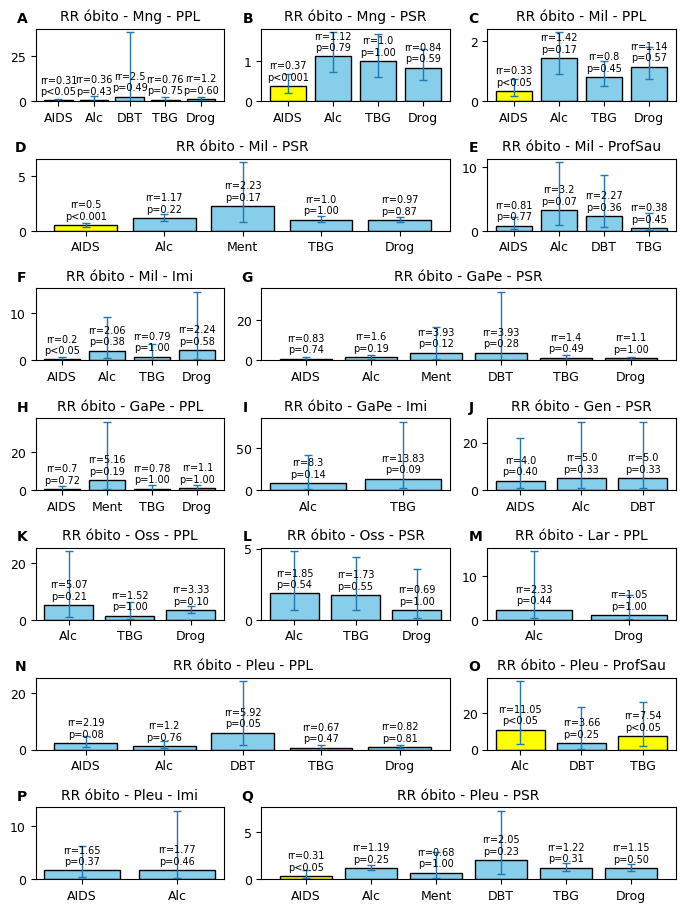

In [10]:
# Configurações para o subplot com add_gridspec
fig = plt.figure(figsize=(8, 14))
gs = fig.add_gridspec(ncols=3, nrows=8, left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.2, hspace=0.8)

# Adicionando gráficos aos subplots
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
plot_rr_with_ci(ax0, df, 'PPL', 'Meningoencefálico', 0)
plot_rr_with_ci(ax1, df, 'PSR', 'Meningoencefálico', 1)
plot_rr_with_ci(ax2, df, 'PPL', 'Miliar', 2)

ax3 = fig.add_subplot(gs[1, 0:2])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
plot_rr_with_ci(ax3, df, 'PSR', 'Miliar', 3, h=-0.05)
plot_rr_with_ci(ax5, df, 'ProfSau', 'Miliar', 4)
plot_rr_with_ci(ax6, df, 'Imi', 'Miliar', 5)

ax7 = fig.add_subplot(gs[2, 1:3])
ax8 = fig.add_subplot(gs[3, 0])
ax9 = fig.add_subplot(gs[3, 1])
plot_rr_with_ci(ax7, df, 'PSR', 'Gang. Perif.', 6, h=-0.05)
plot_rr_with_ci(ax8, df, 'PPL', 'Gang. Perif.', 7)
plot_rr_with_ci(ax9, df, 'Imi', 'Gang. Perif.', 8)

ax10 = fig.add_subplot(gs[3, 2])
plot_rr_with_ci(ax10, df, 'PSR', 'Geniturinária', 9)

ax11 = fig.add_subplot(gs[4, 0])
ax12 = fig.add_subplot(gs[4, 1])
plot_rr_with_ci(ax11, df, 'PPL', 'Óssea', 10)
plot_rr_with_ci(ax12, df, 'PSR', 'Óssea', 11)

ax13 = fig.add_subplot(gs[4, 2])
plot_rr_with_ci(ax13, df, 'PPL', 'Laringea', 12)

ax14 = fig.add_subplot(gs[5, 0:2])
ax15 = fig.add_subplot(gs[5, 2])
ax16 = fig.add_subplot(gs[6, 0])
ax17 = fig.add_subplot(gs[6, 1:3])
plot_rr_with_ci(ax14, df, 'PPL', 'Pleural', 13, h=-0.05)
plot_rr_with_ci(ax15, df, 'ProfSau', 'Pleural', 14)
plot_rr_with_ci(ax16, df, 'Imi', 'Pleural', 15)
plot_rr_with_ci(ax17, df, 'PSR', 'Pleural', 16, h=-0.05)

plt.tight_layout()
plt.show()